# Modeling human movement

## Spatial and temporal features

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pointing_model import PointingModel, features, utils, learning, plotting
import matplotlib.pyplot as plt
import pandas as pd

The ```PointingModel``` class provides utilities for loading, analysing and modeling the data. 

In [3]:
pointing = PointingModel({
    # configure load parameters
    'load_default_fast': True,
    'load': {
        'loading_path': './data_export',
        # 'loading_path': './data',
    },
    # configure normalization
    'normalize': {
        'take_only_final': False
    },
    # load dynamic/temporal features
    'dynamic': {
        'load': True
    },
})

Here we define some default values for the ongoing analyis. The ```feats``` variable contains a list of the desired features.

In [4]:
target_fields = utils.target_fields()
body_fields = utils.all_body_fields()
feats = utils.spatial_features() + utils.temporal_features()

exclude = utils.exclude_temporal_features(utils.spatial_features())

## Feature analys

Plotting the correlation matrix of the base body values with the target labels. Here we can see correlations between a markerset position and a target position, which gives clues about how to engineer features.

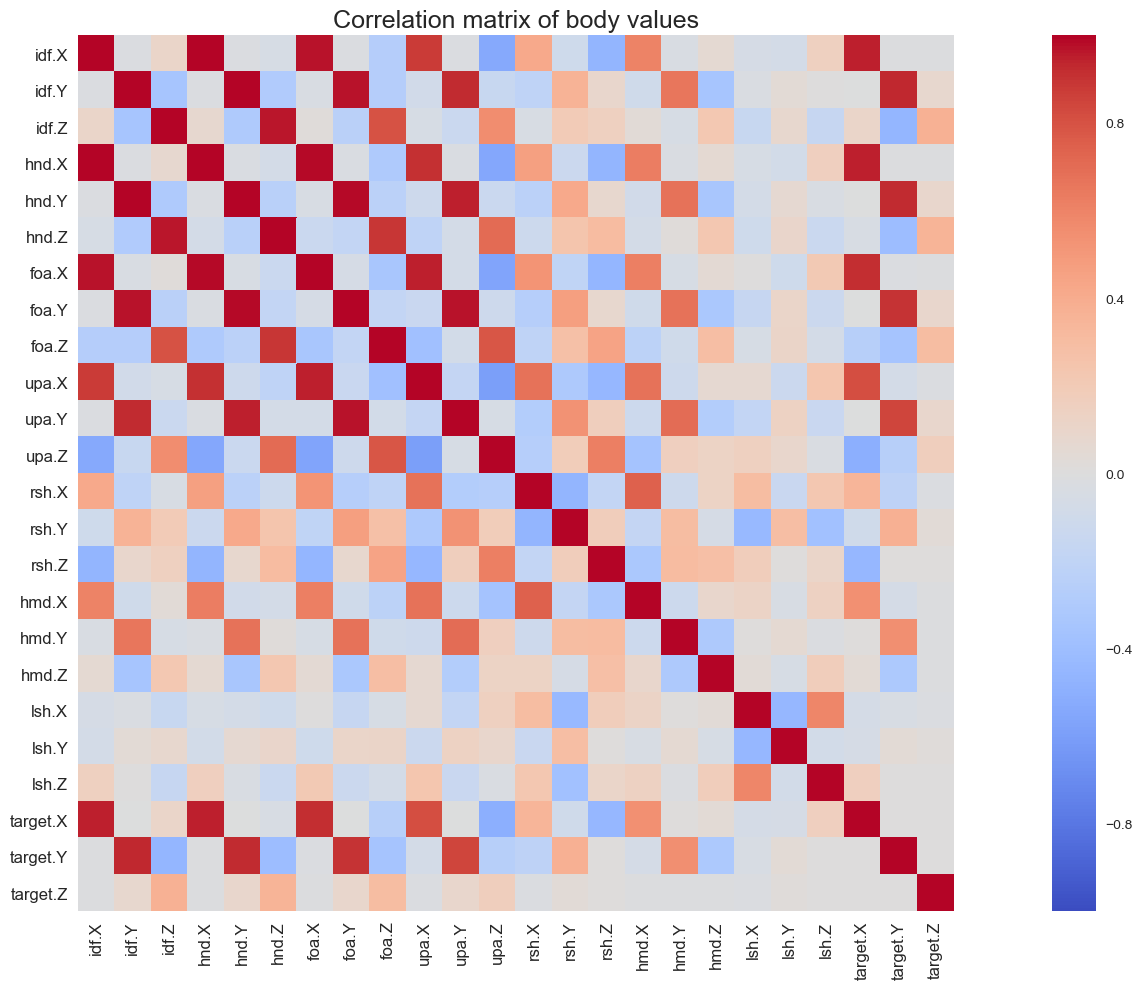

In [5]:
pointing.plot_correlation_matrix(base_fields=body_fields, force=True, additional_fields=target_fields)

Plotting the correlation matrix between the selected features and the target labels.

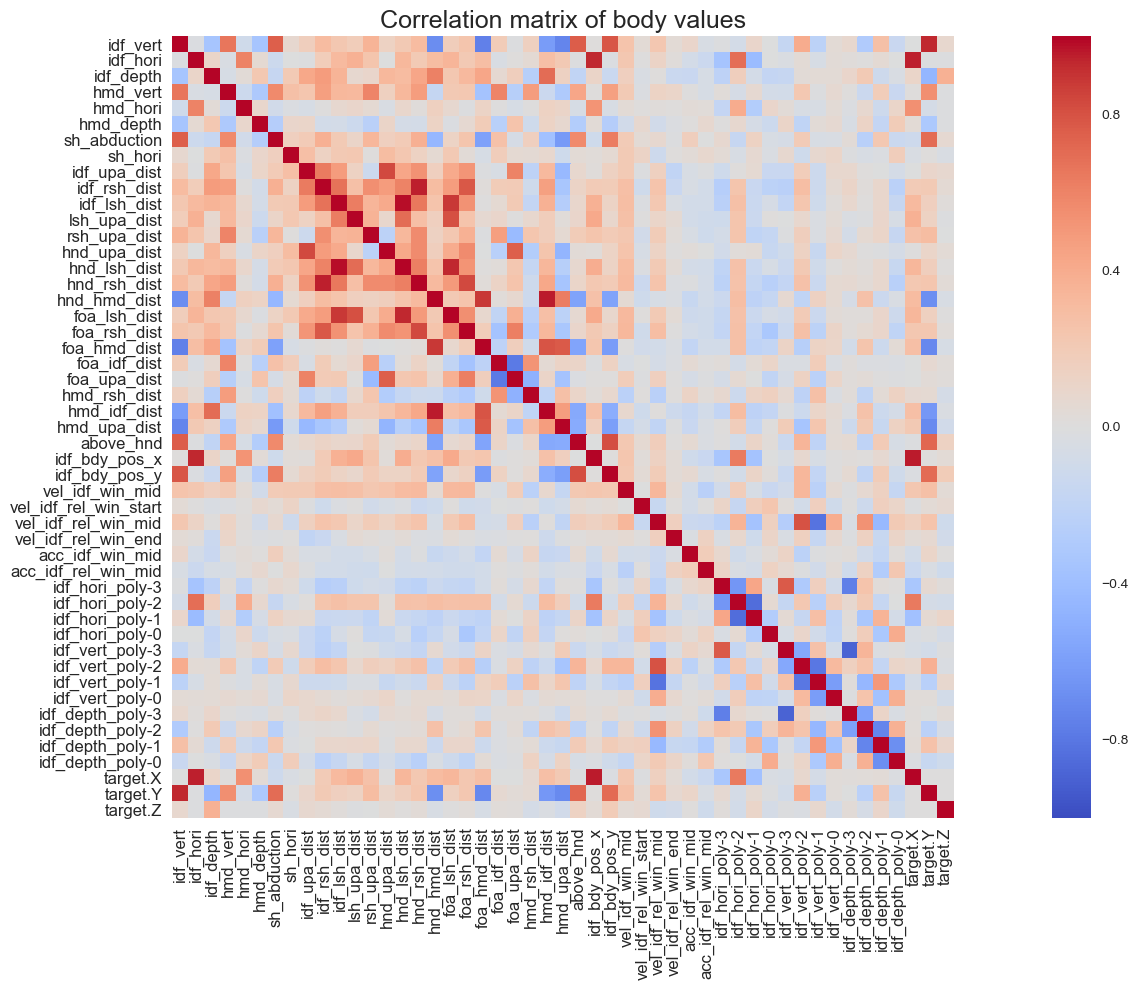

In [6]:
pointing.plot_correlation_matrix(base_fields=feats, force=True, additional_fields=target_fields, exclude_features=exclude)

Plotting the $\chi^2$-test between the selected features and the target labels.

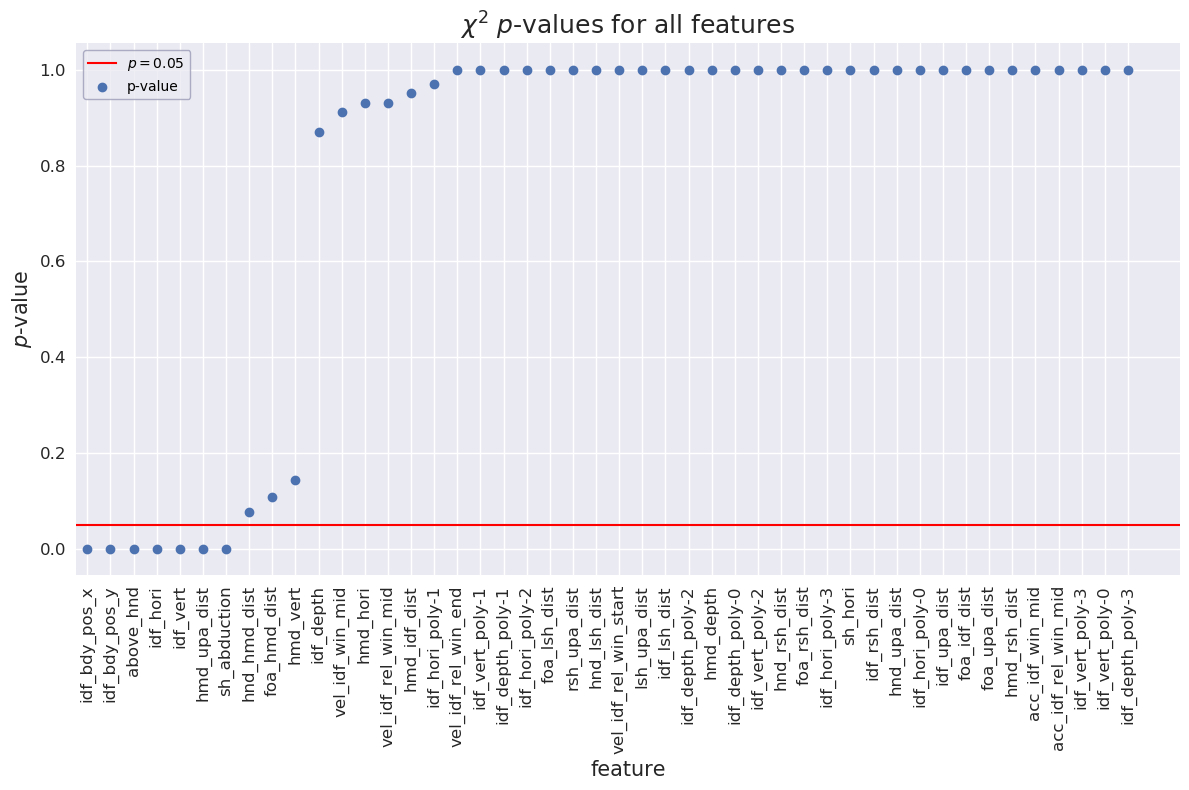

<Figure size 432x288 with 0 Axes>

In [7]:
pointing.plot_selectKBest_chi2(fields=feats, force=True, exclude_features=exclude)

Plotting the mutual information between the selected features and the target labels.

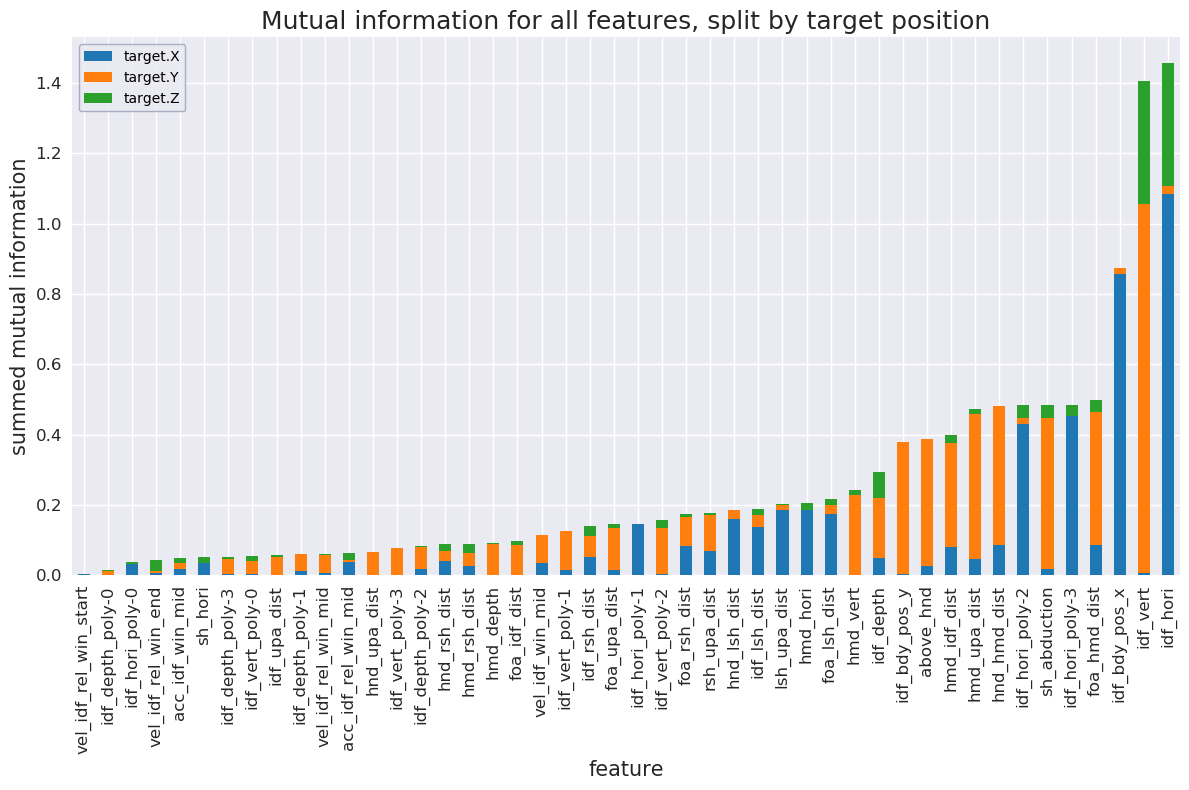

<Figure size 432x288 with 0 Axes>

In [8]:
pointing.plot_selectKBest_mutual_information(fields=feats, force=True, exclude_features=exclude)

Plotting feature importance, using ```sklearn.ensemple.ExtraTreesClassifier``` for computing the importance measure.

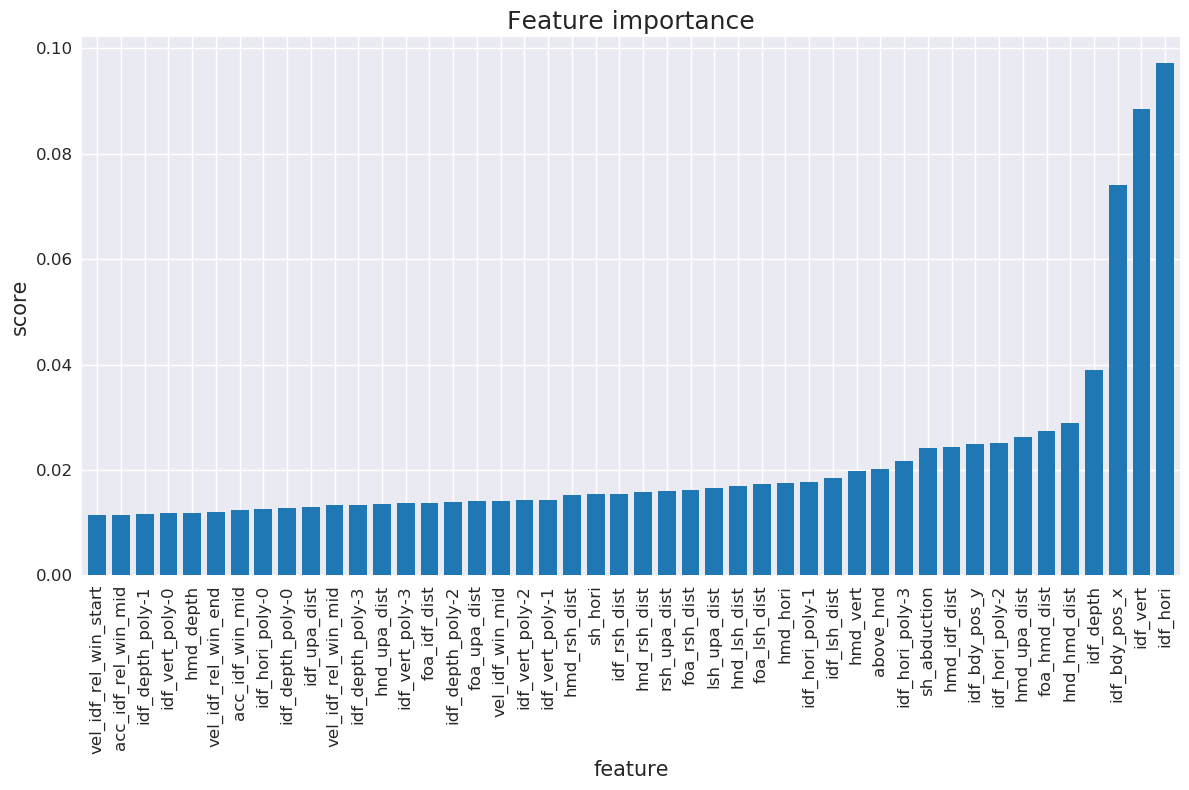

<Figure size 432x288 with 0 Axes>

In [9]:
pointing.plot_extratrees(fields=feats, force=True, exclude_features=exclude)

## Machine learning

### Pipeline
We first conduct a gridsearch, in order to find the best parameters for a model. Then these best parameters are used to train a model on 80% of the dataset. 20% of the data is then used to compute the test score, which we can compare against a 5-fold cross validation score obtained on first mentioned 80% of data.

### Classification

We use three different classification algorithms for comparison: Naive Bayes, SVM and random forest.

In [10]:
c_models = pointing.classification_models
c_models

[pointing_model.learning.models.svm.SupportVectorMachine,
 pointing_model.learning.models.random_forest.RandomForest,
 pointing_model.learning.models.naive_bayes.NaiveBayes]

We first conduct a gridsearch on the models to find the best performing parameters.

In [11]:
c_search = {}
for cm in c_models:
    m, p = pointing.machine_learning_gridsearch(
        cm, features=feats, preprocess_kwargs={'exclude_features': exclude}
    )
    c_search[m.name] = (cm, p)


****

Using:SVM
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       1.00      1.00      1.00        11
(-1.0, 0.49, 2.5)       1.00      1.00      1.00        17
(-1.0, 0.49, 3.5)       1.00      1.00      1.00        13
(-1.0, 1.49, 1.5)       1.00      1.00      1.00        11
(-1.0, 1.49, 2.5)       1.00      1.00      1.00         8
(-1.0, 1.49, 3.5)       1.00      1.00      1.00        13
(-1.0, 2.49, 1.5)       1.00      1.00      1.00        12
(-1.0, 2.49, 2.5)       1.00      1.00      1.00        17
(-1.0, 2.49, 3.5)       1.00      1.00      1.00        17
 (0.0, 0.49, 1.5)       1.00      1.00      1.00        13
 (0.0, 0.49, 2.5)       1.00      1.0

The best parameters are stored in a dictionary for later use in training the models.

In [12]:
c_search

{'SVM': (pointing_model.learning.models.svm.SupportVectorMachine,
  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}),
 'Random Forest': (pointing_model.learning.models.random_forest.RandomForest,
  {'criterion': 'entropy',
   'max_depth': 13,
   'max_features': 'log2',
   'n_estimators': 175,
   'random_state': 0}),
 'Naive Bayes': (pointing_model.learning.models.naive_bayes.NaiveBayes,
  {'var_smoothing': 1e-09})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.


****

Using:SVM
5-fold cross validation score: 0.7763523131672598
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       1.00      1.00      1.00        11
(-1.0, 0.49, 2.5)       0.93      0.82      0.87        17
(-1.0, 0.49, 3.5)       0.80      0.92      0.86        13
(-1.0, 1.49, 1.5)       0.85      1.00      0.92        11
(-1.0, 1.49, 2.5)       0.83      0.62      0.71         8
(-1.0, 1.49, 3.5)       0.92      0.92      0.92        13
(-1.0, 2.49, 1.5)       0.85      0.92      0.88        12
(-1.0, 2.49, 2.5)       0.82      0.82      0.82        17
(-1.0, 2.49, 3.5)       0.94      0.88      0.91        17
 (0.0, 0.49, 1.5)       0.93      1.00      0.96        13
 (0.0, 0.49, 2.5)       0.75      0.75      0.75        16
 (0.0, 0.49, 3.5)       0.75      0.69      0.72        13
 (0.0, 1.49, 1.5)       0.59      0.83      0.69        12
 (0.0, 1.49, 2.5)       0.12      0.12      0.12         8
 (0.0, 1.49, 3.

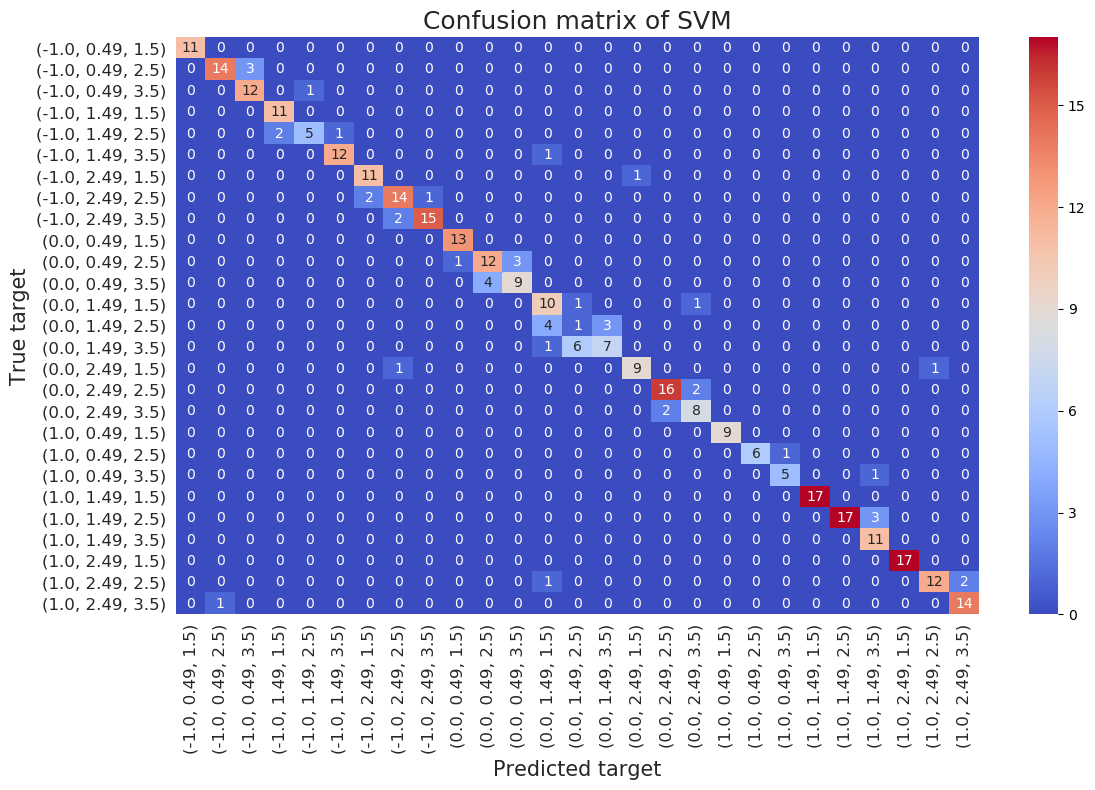

-----------------------

****

Using:Random Forest
5-fold cross validation score: 0.7129588205388917
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.85      1.00      0.92        11
(-1.0, 0.49, 2.5)       0.79      0.65      0.71        17
(-1.0, 0.49, 3.5)       0.64      0.69      0.67        13
(-1.0, 1.49, 1.5)       0.79      1.00      0.88        11
(-1.0, 1.49, 2.5)       0.38      0.38      0.38         8
(-1.0, 1.49, 3.5)       0.58      0.54      0.56        13
(-1.0, 2.49, 1.5)       0.65      0.92      0.76        12
(-1.0, 2.49, 2.5)       0.53      0.59      0.56        17
(-1.0, 2.49, 3.5)       0.89      0.47      0.62        17
 (0.0, 0.49, 1.5)       0.81      1.00      0.90        13
 (0.0, 0.49, 2.5)       0.80      0.50      0.62        16
 (0.0, 0.49, 3.5)       0.69      0.85      0.76        13
 (0.0, 1.49, 1.5)       0.82      0.75      0.78        12
 (0.0, 1.49, 2.5)       0.08      0.12  

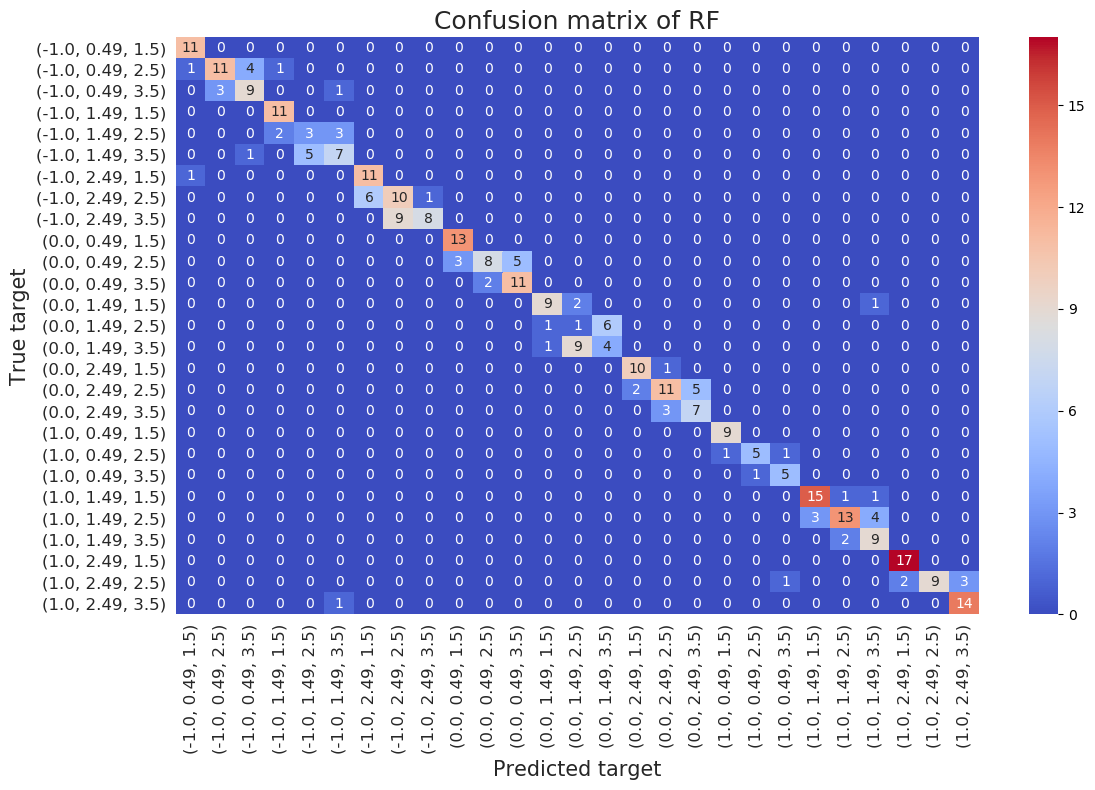

-----------------------

****

Using:Naive Bayes
5-fold cross validation score: 0.4793365531265887
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.50      1.00      0.67        11
(-1.0, 0.49, 2.5)       0.33      0.06      0.10        17
(-1.0, 0.49, 3.5)       0.40      0.31      0.35        13
(-1.0, 1.49, 1.5)       0.36      0.45      0.40        11
(-1.0, 1.49, 2.5)       0.17      0.50      0.26         8
(-1.0, 1.49, 3.5)       0.33      0.15      0.21        13
(-1.0, 2.49, 1.5)       0.30      0.75      0.43        12
(-1.0, 2.49, 2.5)       0.25      0.06      0.10        17
(-1.0, 2.49, 3.5)       0.60      0.35      0.44        17
 (0.0, 0.49, 1.5)       0.48      1.00      0.65        13
 (0.0, 0.49, 2.5)       0.38      0.19      0.25        16
 (0.0, 0.49, 3.5)       0.25      0.08      0.12        13
 (0.0, 1.49, 1.5)       0.67      0.17      0.27        12
 (0.0, 1.49, 2.5)       0.17      0.50    

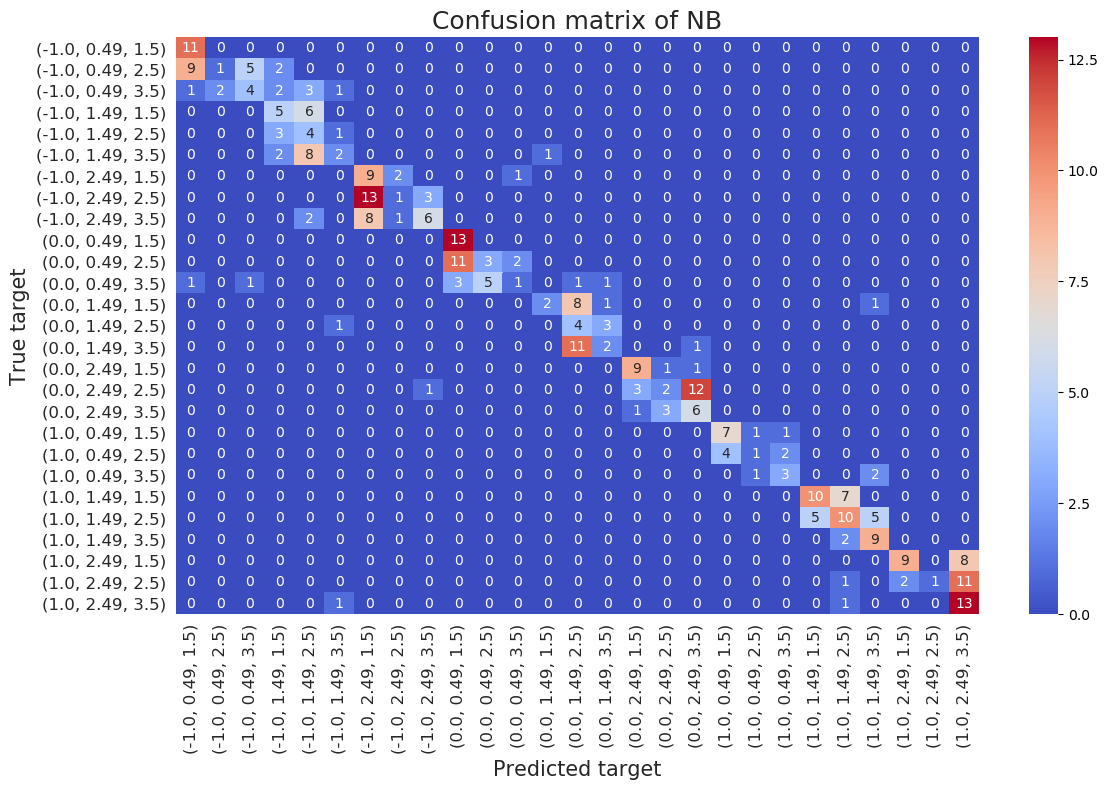

-----------------------


In [13]:
c_scores = {}
for k in c_search:
    cm, p = c_search[k]
    m, s = pointing.machine_learning_kfold(
        cm, model_kwargs=p, cleanup=True, save=False, features=feats,
        preprocess_kwargs={'exclude_features': exclude}
    )
    c_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [14]:
pd.DataFrame.from_dict(c_scores).T

cross-validation  accuracy  f1-score
SVM                    0.776352  0.849003  0.834057
Random Forest          0.712959  0.715100  0.704578
Naive Bayes            0.479337  0.421652  0.387759

### Regression

Also for regression we compare three different models: Linear Regression, SVM and random forest.

In [15]:
 r_models = pointing.regression_models
 r_models

[pointing_model.learning.models.svm.SupportVectorMachineRegression,
 pointing_model.learning.models.random_forest.RandomForestRegression,
 pointing_model.learning.models.linear_regression.LinearRegression]

We first conduct a gridsearch on the models to find the best performing parameters.

In [16]:
r_search = {'Linear Regression': (learning.LinearRegression, {})}
for rm in r_models:
    m, p = pointing.machine_learning_gridsearch(
        rm, features=feats, preprocess_kwargs={'exclude_features': exclude}
    )
    r_search[m.name] = (rm, p)


****

Using:SVM
# Tuning hyper-parameters
Best parameters set found on development set:
{'estimator__C': 10.0, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.04  0.42  1.60  0.35
                    2.5       -0.98  0.56  2.47  0.21
                    3.5       -0.79  0.77  2.76  0.89
          1.49      1.5       -1.11  1.50  2.36  0.87
                    2.5       -0.92  1.51  2.67  0.27
                    3.5       -0.78  1.54  3.00  0.64
          2.49      1.5       -1.01  2.54  1.78  0.32
                    2.5       -0.91  2.38  2.33  0.36
                    3.5       -0.75  2.29  2.77  0.88
 0.0      0.49 

AttributeError: 'MultiOutputRegressor' object has no attribute 'best_params_'

The best parameters are stored in a dictionary for later use in training the models.

In [17]:
r_search

{'SVM': (pointing_model.learning.models.svm.SupportVectorMachineRegression,
  {'estimator__C': 10.0,
   'estimator__gamma': 0.001,
   'estimator__kernel': 'rbf'}),
 'Random Forest Regression': (pointing_model.learning.models.random_forest.RandomForestRegression,
  {'criterion': 'mae',
   'max_depth': 16,
   'max_features': 'auto',
   'n_estimators': 150,
   'random_state': 0}),
 'Linear Regression': (pointing_model.learning.models.linear_regression.LinearRegression,
  {})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.


****

Using:SVM
5-fold cross validation score: 0.348685915075641

Description of distances:
count    27.000000
mean      0.247015
std       0.194710
min       0.042475
25%       0.125782
50%       0.187784
75%       0.308635
max       0.927274
Name: (dist, real_mean), dtype: float64



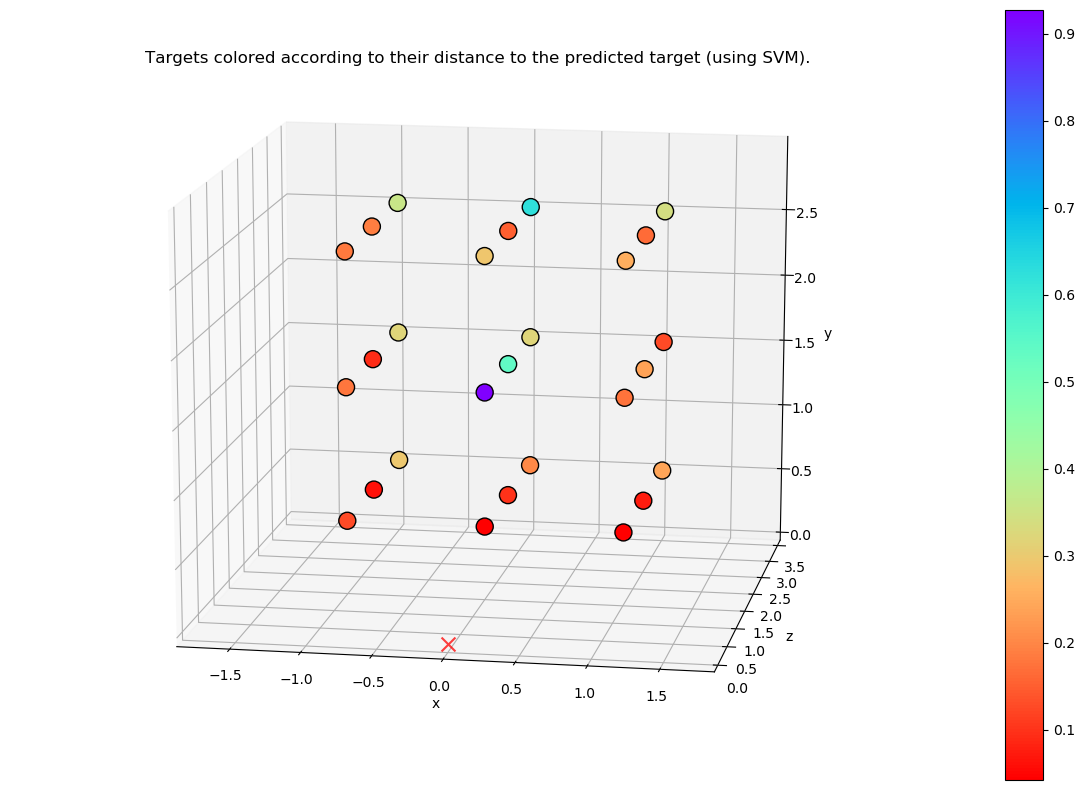

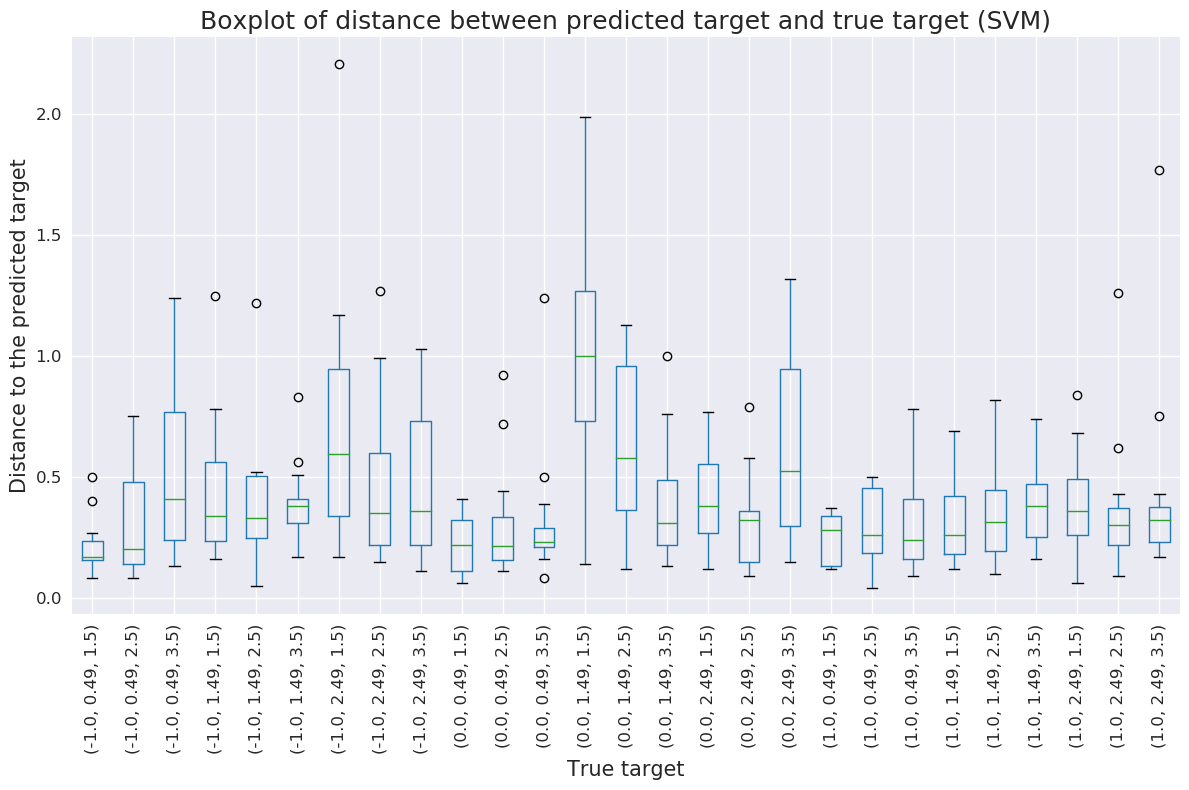

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -0.99  0.50  1.38  0.22
                    2.5       -1.00  0.49  2.56  0.33
                    3.5       -0.81  0.61  3.30  0.53
          1.49      1.5       -1.13  1.50  1.63  0.45
                    2.5       -0.95  1.53  2.57  0.42
                    3.5       -0.87  1.51  3.21  0.40
          2.49      1.5       -0.94  2.44  1.67  0.73
                    2.5       -0.93  2.42  2.66  0.45
                    3.5       -0.84  2.35  3.21  0.46
 0.0      0.49      1.5        0.01  0.48  1.46  0.22
                    2.5       -0.04  0.50  2.41  0.31
                    3.5       -0.00  0.60  3.33  0.33
          1.49      1.5        0.01  1.43  2.43  1.03
                    2.5       -0.06  1.42  3.03  0.64
                    3.5       -0.05  1.59  3.20

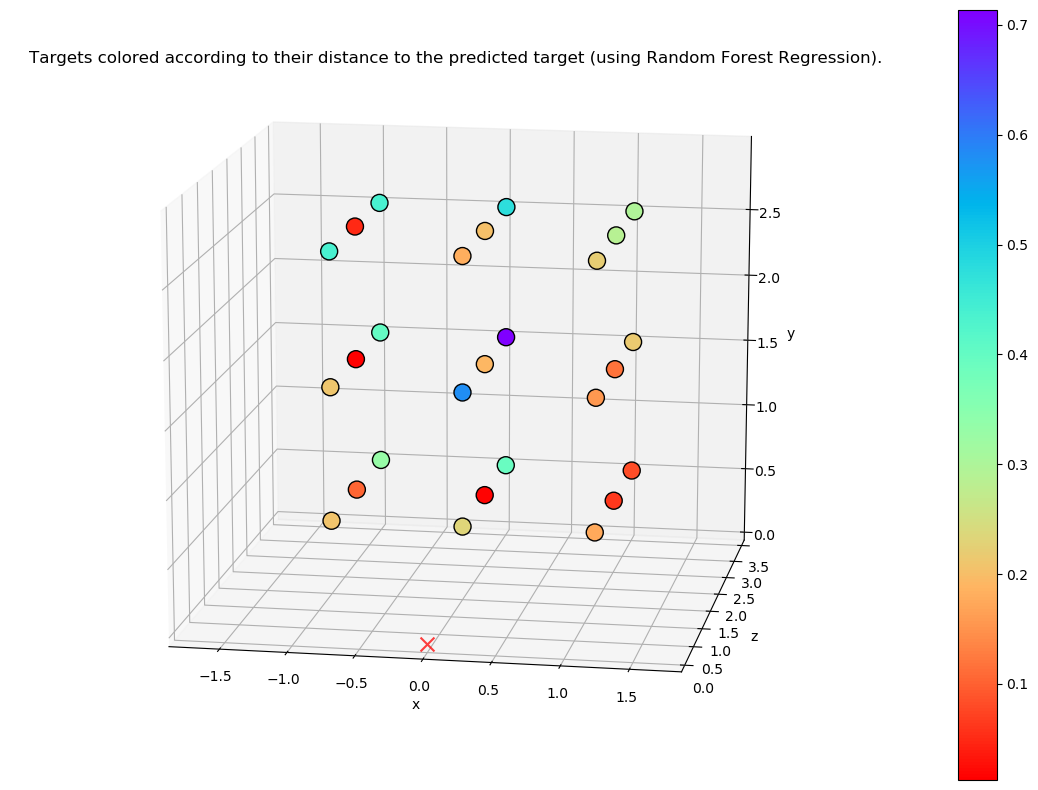

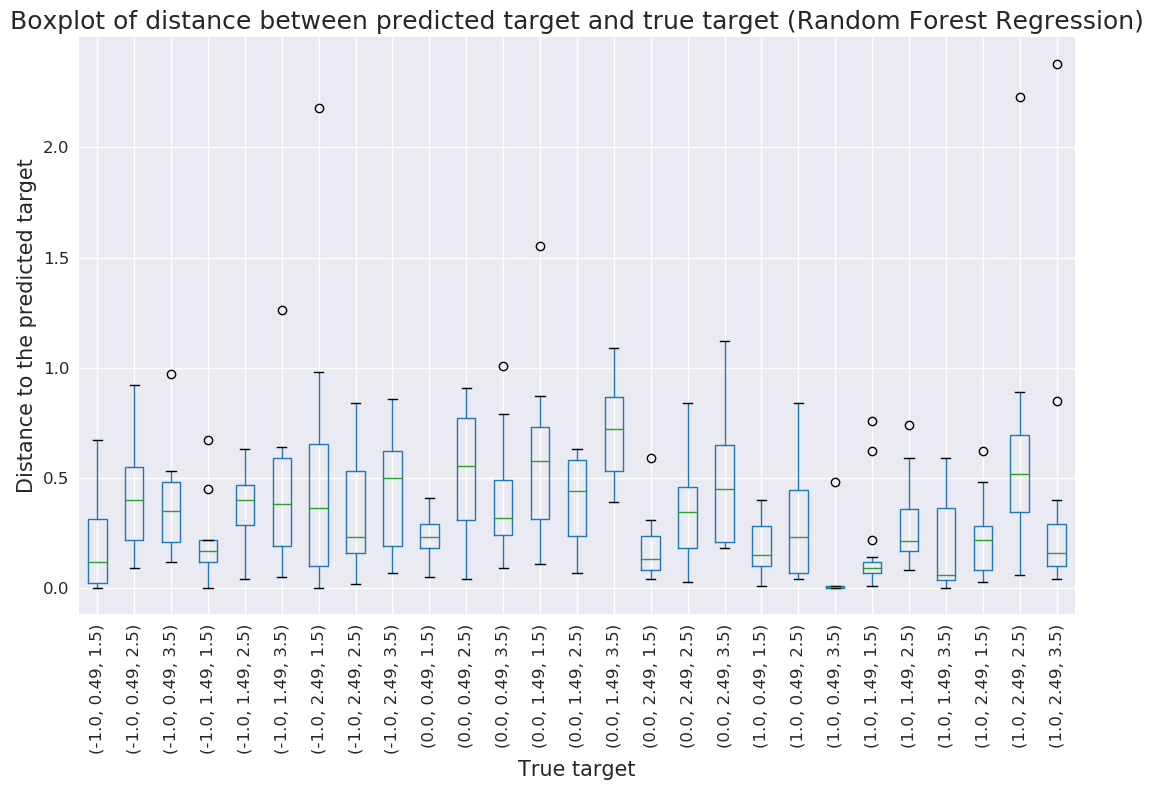

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.00  0.49  1.71  0.21
                    2.5       -1.00  0.50  2.60  0.43
                    3.5       -1.00  0.56  3.18  0.37
          1.49      1.5       -1.00  1.48  1.71  0.22
                    2.5       -1.00  1.49  2.51  0.36
                    3.5       -1.00  1.41  3.11  0.43
          2.49      1.5       -1.00  2.32  1.90  0.52
                    2.5       -1.00  2.49  2.45  0.36
                    3.5       -1.00  2.47  3.06  0.45
 0.0      0.49      1.5        0.01  0.50  1.73  0.24
                    2.5        0.01  0.50  2.51  0.52
                    3.5        0.00  0.56  3.11  0.41
          1.49      1.5        0.03  1.45  2.08  0.59
                    2.5        0.00  1.49  2.69  0.40
                    3.5        0.00  1.48  2.79

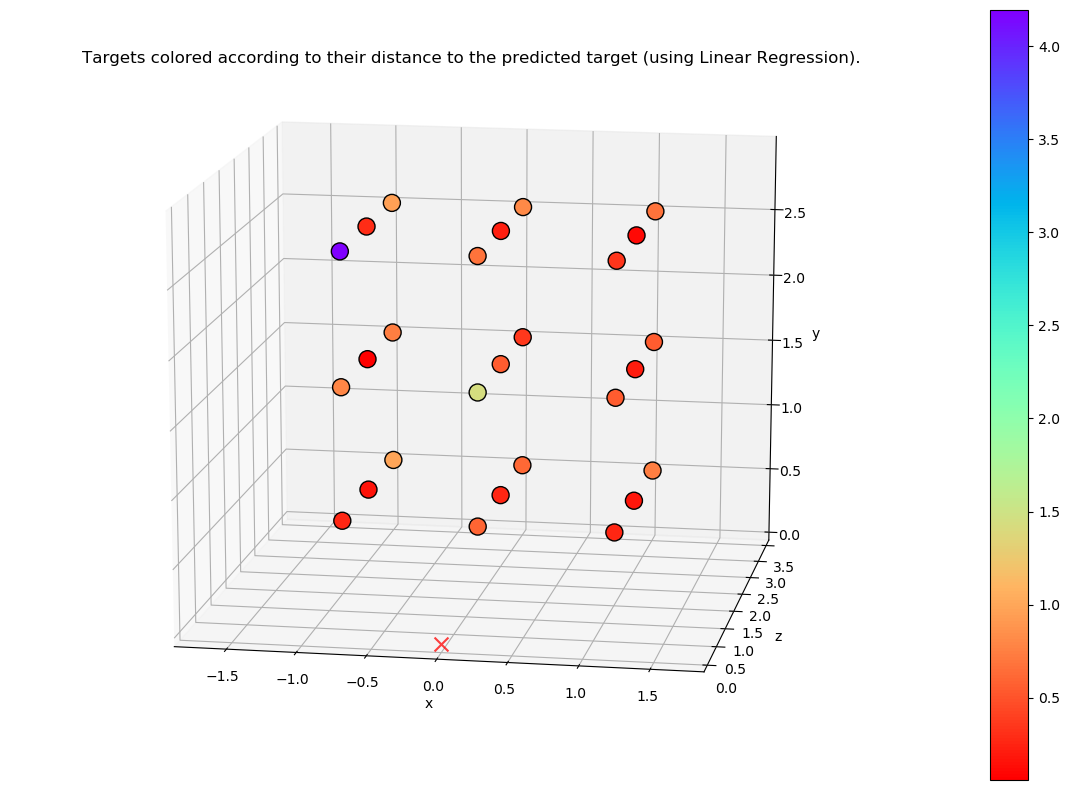

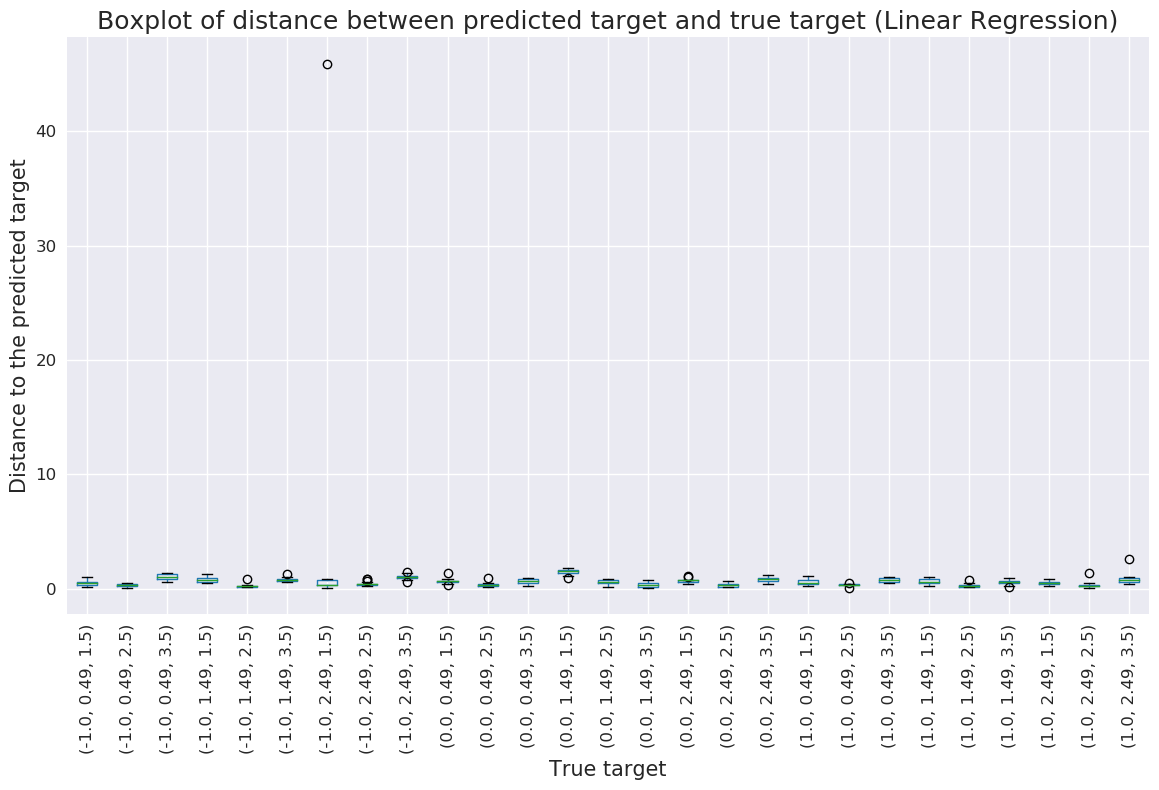

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.11  0.41  1.73  0.50
                    2.5       -1.00  0.65  2.49  0.30
                    3.5       -0.79  0.84  2.61  1.02
          1.49      1.5       -1.15  1.51  2.28  0.81
                    2.5       -0.95  1.50  2.53  0.28
                    3.5       -0.76  1.50  2.79  0.81
          2.49      1.5       -1.51  3.31  5.58  4.22
                    2.5       -0.88  2.35  2.26  0.43
                    3.5       -0.70  2.21  2.64  1.02
 0.0      0.49      1.5       -0.04  0.05  1.90  0.67
                    2.5       -0.04  0.52  2.76  0.37
                    3.5       -0.07  0.74  2.95  0.64
          1.49      1.5        0.03  1.35  2.94  1.46
                    2.5       -0.09  1.41  3.04  0.57
                    3.5       -0.04  1.47  3.15

In [18]:
r_scores = {}
for k in r_search:
    cm, p = r_search[k]
    p = {i.replace('estimator__', ''): p[i] for i in p}
    m, s = pointing.machine_learning_kfold(
        cm, model_kwargs=p, cleanup=True, features=feats,
        analyze_distances=plotting.analyze_distances, save=False,
        preprocess_kwargs={'exclude_features': exclude}
    )
    r_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [19]:
pd.DataFrame.from_dict(r_scores).T

cross-validation  mean_distance      rmse
SVM                               0.348686       0.247015  0.303402
Random Forest Regression          0.274114       0.252101  0.280844
Linear Regression                 0.475815       0.652697  1.471273